In [1]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv('speakers_all.csv')
df.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [3]:
path='recordings/recordings/'
df = df[df['file_missing?'] != True]
df.shape

(2138, 12)

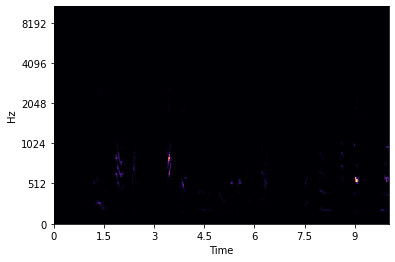

In [5]:
y, sr = librosa.load('recordings/recordings/english385.mp3', duration=10.0)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [6]:
ps.shape

(128, 431)

In [7]:
import numpy as np
from tqdm import tqdm

D = [] # Dataset

for index_num,row in tqdm(df.iterrows()):
    file_name = 'recordings/recordings/' + str(row["filename"]) + '.mp3'
    y, sr = librosa.load(file_name, duration=10.0)  
    ps = librosa.feature.melspectrogram(y=y, sr=sr)
    if ps.shape != (128, 431): continue
    D.append( (ps, row["sex"]) )

2138it [22:36,  1.58it/s]


In [8]:
extracted_features_df=pd.DataFrame(D,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[[0.09874383, 0.2513699, 0.25507128, 0.2234160...",female
1,"[[2.1711987e-06, 2.455684e-06, 2.3796056e-06, ...",male
2,"[[0.0062513114, 0.005870834, 0.0032840488, 0.0...",male
3,"[[0.00051681005, 0.00050841906, 0.00052578124,...",male
4,"[[0.595527, 2.6488352, 4.0519133, 2.793845, 0....",male


In [9]:
extracted_features_df.to_csv('MFSG_Extracted_features.csv', index=False)

In [19]:
import random

dataset = D
random.shuffle(dataset)

train = dataset[:2000]
test = dataset[2000:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array(X_train)
X_test = np.array(X_test)

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
#y=to_categorical(labelencoder.fit_transform(y))
#y
y_train = np.array(to_categorical(labelencoder.fit_transform(y_train)))
y_test = np.array(to_categorical(labelencoder.fit_transform(y_test)))

In [21]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2000, 128, 431), (138, 128, 431), (2000, 2), (138, 2))

In [23]:
import tensorflow.keras as keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D

input_shape=(128,431)

model = keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               286720    
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 128)               0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 128)               16512     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 64)                8256      
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 64)                0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 48)                3120      
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 48)               

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved models/Gender_Classifier_RNN.hdf5', 
                               verbose=1, save_weights_only=True)

model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy'])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=50,
    batch_size=32,
    callbacks=[checkpointer],
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
63/63 [==============================] - 9s 109ms/step - loss: 0.0992 - accuracy: 0.9710 - val_loss: 1.7801 - val_accuracy: 0.6377

Epoch 00001: saving model to saved models\Gender_Classifier_RNN.hdf5
Epoch 2/50
63/63 [==============================] - 7s 113ms/step - loss: 0.0451 - accuracy: 0.9850 - val_loss: 2.4573 - val_accuracy: 0.5652

Epoch 00002: saving model to saved models\Gender_Classifier_RNN.hdf5
Epoch 3/50
63/63 [==============================] - 9s 143ms/step - loss: 0.0254 - accuracy: 0.9950 - val_loss: 2.6366 - val_accuracy: 0.5942

Epoch 00003: saving model to saved models\Gender_Classifier_RNN.hdf5
Epoch 4/50
63/63 [==============================] - 10s 151ms/step - loss: 0.0253 - accuracy: 0.9925 - val_loss: 3.1376 - val_accuracy: 0.5580

Epoch 00004: saving model to saved models\Gender_Classifier_RNN.hdf5
Epoch 5/50
63/63 [==============================] - 9s 150ms/step - loss: 0.0533 - accuracy: 0.9830 - val_loss: 2.2400 - val_accuracy: 0.5652

Epoch 00

63/63 [==============================] - 9s 147ms/step - loss: 9.4713e-05 - accuracy: 1.0000 - val_loss: 3.9140 - val_accuracy: 0.6449

Epoch 00039: saving model to saved models\Gender_Classifier_RNN.hdf5
Epoch 40/50
63/63 [==============================] - 9s 146ms/step - loss: 4.0002e-05 - accuracy: 1.0000 - val_loss: 3.9835 - val_accuracy: 0.6449

Epoch 00040: saving model to saved models\Gender_Classifier_RNN.hdf5
Epoch 41/50
63/63 [==============================] - 9s 146ms/step - loss: 1.2005e-04 - accuracy: 1.0000 - val_loss: 4.0548 - val_accuracy: 0.6449

Epoch 00041: saving model to saved models\Gender_Classifier_RNN.hdf5
Epoch 42/50
63/63 [==============================] - 9s 151ms/step - loss: 7.3094e-05 - accuracy: 1.0000 - val_loss: 4.1378 - val_accuracy: 0.6449

Epoch 00042: saving model to saved models\Gender_Classifier_RNN.hdf5
Epoch 43/50
63/63 [==============================] - 9s 142ms/step - loss: 2.4508e-05 - accuracy: 1.0000 - val_loss: 4.1856 - val_accuracy: 0.64

In [35]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/50
28/28 [==============================] - 7s 195ms/step - loss: 0.0100 - accuracy: 0.9965 - val_loss: 6.1981 - val_accuracy: 0.6377
Epoch 2/50
28/28 [==============================] - 5s 177ms/step - loss: 0.0717 - accuracy: 0.9845 - val_loss: 2.9049 - val_accuracy: 0.6159
Epoch 3/50
28/28 [==============================] - 6s 233ms/step - loss: 0.0146 - accuracy: 0.9965 - val_loss: 2.7484 - val_accuracy: 0.6159
Epoch 4/50
28/28 [==============================] - 7s 247ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 3.3254 - val_accuracy: 0.6449
Epoch 5/50
28/28 [==============================] - 7s 250ms/step - loss: 4.9008e-04 - accuracy: 1.0000 - val_loss: 3.5885 - val_accuracy: 0.6377
Epoch 6/50
28/28 [==============================] - 7s 251ms/step - loss: 2.0501e-04 - accuracy: 1.0000 - val_loss: 3.7490 - val_accuracy: 0.6377
Epoch 7/50
28/28 [==============================] - 7s 247ms/step - loss: 1.1105e-04 - accuracy: 1.0000 - val_loss: 3.8913 - val_accuracy: 0

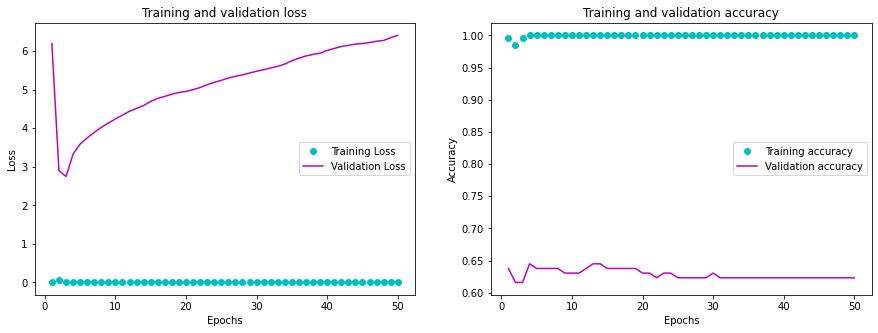

In [38]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,51)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [39]:
model.predict_classes(X_test)

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1], dtype=int64)

In [41]:
file_name = "recordings/recordings/english381.mp3"
y, sr = librosa.load(file_name, duration=10.0)  
ps = librosa.feature.melspectrogram(y=y, sr=sr)
d=[]
d.append( (ps, "null") )

x, y = zip(*d)
x = np.array(x)

predict = model.predict_classes(x)
prediction_class = labelencoder.inverse_transform(predict)
prediction_class

array(['female'], dtype='<U6')